In [ ]:
# Install necessary packages
!pip install numpy matplotlib scipy networkx qiskit mqt-bench scikit-learn
# Install the latest version of the mqt-predictor
!pip install git+https://github.com/cda-tum/mqt-predictor.git@main

In [43]:
# Standard library imports
import os
import glob
import ast
import random
import copy

# Numerical and scientific computing
import numpy as np
import scipy as sp
from scipy.stats import pearsonr, ConstantInputWarning

# Visualization
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator

# Graph analysis
import networkx as nx

# Qiskit and quantum computing
from qiskit import QuantumCircuit
import qiskit.qasm3
from qiskit.converters import circuit_to_dag

# MQT predictor and benchmarking tools
import mqt.bench
from mqt.predictor.reward import expected_fidelity, estimated_success_probability

# Machine learning with scikit-learn
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split, KFold, ParameterGrid
from sklearn.inspection import permutation_importance

# Suppress specific warnings
import warnings
warnings.filterwarnings("ignore", category=UserWarning, module="sklearn.ensemble._forest")
warnings.filterwarnings("ignore", category=ConstantInputWarning)

In [44]:
# Get current directory path
directory = os.getcwd()
fig_path = os.getcwd() + "/figures"

In [45]:
# Prepare plots

# Set Helvetica as the default font
plt.rcParams['font.family'] = 'Helvetica'
colors = {
    "blue": "#648FFF",
    "purple": "#785EF0",
    "pink": "#DC267F",
    "yellow": "#FFB000",
    "orange": "#FE6100"
}

# Configure matplotlib to match LaTeX setup
plt.rcParams.update({
    "text.usetex": True,  # Enable LaTeX
    "font.family": "sans-serif",  # Base font is sans-serif
    "font.sans-serif": ["Helvetica"],  # Use Helvetica for text
    "mathtext.fontset": "cm",  # Computer Modern for math
    "font.size": 11,  # Base font size
    "text.latex.preamble": r"""
        \usepackage{amsmath}
        \usepackage{amsfonts}
        \usepackage{amssymb}
        \usepackage{upgreek}
    """,  # Include AMS and upright Greek support
    "axes.labelsize": 11,  # Axis label size
    "axes.titlesize": 11,  # Title size
    "xtick.labelsize": 11,  # X-axis tick font size
    "ytick.labelsize": 11,  # Y-axis tick font size
    "legend.fontsize": 11,  # Legend font size
    "figure.dpi": 72, # Latex
})

# Prepare the circuit data

In [46]:
# Helper functions

def hellinger_distance(p, q):
    assert np.isclose(np.sum(p), 1, 0.1), "p is not a probability distribution"
    assert np.isclose(np.sum(q), 1, 0.1), "q is not a probability distribution"

    hell = (1 / np.sqrt(2)) * np.sqrt(np.sum((np.sqrt(p) - np.sqrt(q)) ** 2))
    return hell

def qft_hellinger(file_name, states, execution_probs_all):
    # Get the number of qubits
    num_qubits = int(file_name.split('_')[-1])
    num_of_states = 2 ** num_qubits
    equal_fraction_value = 1 / num_of_states
    noiseless_probs_all = np.array([equal_fraction_value for state in states])
    # Calculate the Hellinger distance
    hellinger = (1 / np.sqrt(2)) * np.sqrt(np.sum((np.sqrt(noiseless_probs_all) - np.sqrt(execution_probs_all)) ** 2))
    # How many states are not in the experiment data
    missing_states = num_of_states - len(states)
    # Add missing states to the Hellinger distance
    hellinger += (1 / np.sqrt(2)) * (missing_states * equal_fraction_value)
    return hellinger

In [47]:
# Dictionaries to store the calculated figures of merit and Hellinger distance
depth, esp, fidelity, num_gates, hellinger = {}, {}, {}, {}, {}

qpus = ['apollo', 'qexa'] 
for qpu in qpus:
    depth[qpu], esp[qpu], fidelity[qpu], num_gates[qpu], hellinger[qpu] = {}, {}, {}, {}, {}

    # Import qpus
    try:
        device = mqt.bench.devices.get_device_by_name('iqm_' + qpu)
    except Exception as e:
        # Device 'iqm_qexa' not yet publicly available
        print(f"Device 'iqm_{qpu}' not found among available providers.")
        print(f"Will use the precomputed ESP and fidelity values.")
        device = None
    
    # Get a list of all execution files
    execution_files = sorted(glob.glob(os.path.join(directory, 'execution', qpu, '*.txt')))
    print(f"Found {len(execution_files)} execution files for {qpu}")

    # Iterate over the execution files
    for execution_file in execution_files:
        # file_name is sth. like 'qft_10'
        file_name = os.path.basename(execution_file).replace(".txt", "")
        try:
            # Load the corresponding circuit
            circuit = qiskit.qasm2.load(os.path.join(directory, 'qasm', file_name + '.qasm'))

            # Load the noiseless simulation file
            noiseless_file = os.path.join(directory, 'simulation', qpu, file_name + '.txt')

            # Open the files and read the counts
            with open(noiseless_file, 'r') as f:
                noiseless_counts = ast.literal_eval(f.read())
            with open(execution_file, 'r') as f:
                execution_counts = ast.literal_eval(f.read())

            num_execution_shots = sum(execution_counts.values())
            num_noiseless_shots = sum(noiseless_counts.values())

            # Transform counts to probabilities
            noiseless_probs_org = {k: v / num_noiseless_shots for k, v in noiseless_counts.items()}

            # Only keep the states that are distinguishable with the number of execution shots
            noiseless_probs = {k: v for k, v in noiseless_probs_org.items() if v * num_execution_shots >= 1}

            # Get the states and their noiseless probabilities
            states = sorted(set(noiseless_counts.keys()).union(execution_counts.keys()))
            noiseless_probs_all = np.array([noiseless_probs.get(state, 0) for state in states])

            # Get the execution probabilities
            execution_counts_all = np.array([execution_counts.get(state, 0) for state in states])
            execution_probs_all = execution_counts_all / num_execution_shots
            

            # If they no longer resemble a probability distribution, skip the file
            if not np.isclose(sum(noiseless_probs_all), 1, 0.05) or not np.isclose(sum(execution_probs_all), 1, 0.05):
                
                # Special case for QFTs = uniform distribution over all states
                if 'qft' in file_name and not 'entangled' in file_name:
                    num_qubits = int(file_name.split('_')[-1])
                    # Skip QFTs with more than 8 qubits
                    if num_qubits > 8:
                        continue
                    else:
                        pass
                else:
                    print(f"Skipping {file_name} because probabilities do not sum to 1")
                    continue
            

            # File paths for the figures of merit
            path = os.path.join(directory, 'foms', qpu, file_name)

            num_gates_file = f'{path}_num_gates.txt'
            depth_file = f'{path}_depth.txt'
            fidelity_file = f'{path}_fidelity.txt'
            esp_file = f'{path}_esp.txt'

            # Hellinger distance will be saved as labels
            labels_file = os.path.join(directory, 'labels', qpu, file_name)
            hellinger_file = f'{labels_file}_hellinger.txt'

            # Calculate all values and save them to a file
            # or load them from the file if it exists

            # Depth
            if not os.path.exists(depth_file):
                d = circuit.depth()
                with open(depth_file, 'w') as f:
                    f.write(str(d))
            else:
                with open(depth_file, 'r') as f:
                    d = int(f.read())
            if d > 1000:
                print(f"Skipping {file_name} because depth is too high")
                continue
            depth[qpu][file_name] = d

            # Fidelity
            if not os.path.exists(fidelity_file):
                fidelity[qpu][file_name] = expected_fidelity(circuit, device)
                with open(fidelity_file, 'w') as f:
                    f.write(str(fidelity[qpu][file_name]))
            else:
                with open(fidelity_file, 'r') as f:
                    fidelity[qpu][file_name] = float(f.read())

            # ESP
            if not os.path.exists(esp_file):
                esp[qpu][file_name] = estimated_success_probability(circuit, device)
                with open(esp_file, 'w') as f:
                    f.write(str(esp[qpu][file_name]))
            else:
                with open(esp_file, 'r') as f:
                    esp[qpu][file_name] = float(f.read())
            
            # Number of gates
            if not os.path.exists(num_gates_file):
                num_gates[qpu][file_name] = sum(circuit.count_ops().values())
                with open(num_gates_file, 'w') as f:
                    f.write(str(num_gates[qpu][file_name]))
            else:
                with open(num_gates_file, 'r') as f:
                    num_gates[qpu][file_name] = int(f.read())

            # Execution vs noiseless Hellinger distance
            if not os.path.exists(hellinger_file):

                # Special case for QFT
                if 'qft' in file_name and not 'entangled' in file_name:
                    hellinger[qpu][file_name] = qft_hellinger(file_name, qpu, hellinger, states, execution_probs_all)
                else:
                    hellinger[qpu][file_name] = hellinger_distance(noiseless_probs_all, execution_probs_all)
                with open(hellinger_file, 'w') as f:
                    f.write(str(hellinger[qpu][file_name]))
            else:
                with open(hellinger_file, 'r') as f:
                    hellinger[qpu][file_name] = float(f.read())

        except Exception as e:
            print(f"Error processing {qpu}: {e}")
            continue

Found 390 execution files for apollo
Skipping graphstate_indep_qiskit_10 because probabilities do not sum to 1
Skipping graphstate_indep_qiskit_11 because probabilities do not sum to 1
Skipping graphstate_indep_qiskit_12 because probabilities do not sum to 1
Skipping graphstate_indep_qiskit_13 because probabilities do not sum to 1
Skipping graphstate_indep_qiskit_14 because probabilities do not sum to 1
Skipping graphstate_indep_qiskit_15 because probabilities do not sum to 1
Skipping graphstate_indep_qiskit_16 because probabilities do not sum to 1
Skipping graphstate_indep_qiskit_17 because probabilities do not sum to 1
Skipping graphstate_indep_qiskit_18 because probabilities do not sum to 1
Skipping graphstate_indep_qiskit_20 because probabilities do not sum to 1
Skipping groundstate_large_indep_qiskit_14 because probabilities do not sum to 1
Skipping groundstate_medium_indep_qiskit_12 because probabilities do not sum to 1
Error processing apollo: /Users/patrickhopf/Code/masterthesi

# CORRELATION PLOTS

In [48]:
cols = ['#FE6100', '#648FFF']
names = ['Q20-A', 'Q20-B']

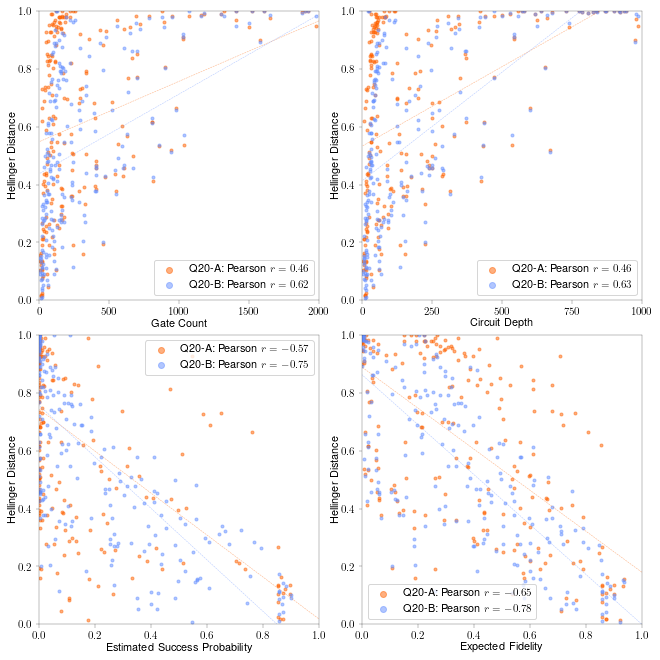

In [49]:
fig, axs = plt.subplots(2, 2, figsize=(9, 9))
data = {}
for i, qpu in enumerate(qpus):

    # Collect data for plot
    depth_list = list(depth[qpu].values())
    esp_list = list(esp[qpu].values())
    fidelity_list = list(fidelity[qpu].values())
    num_gates_list = list(num_gates[qpu].values())
    execution_noiseless_dist_list = list(hellinger[qpu].values())

    data[qpu] = [   
        (num_gates_list, execution_noiseless_dist_list, 'Gate Count', 'Hellinger Distance'),
        (depth_list, execution_noiseless_dist_list, 'Circuit Depth', 'Hellinger Distance'),
        (esp_list, execution_noiseless_dist_list, 'Estimated Success Probability', 'Hellinger Distance'),
        (fidelity_list, execution_noiseless_dist_list, 'Expected Fidelity', 'Hellinger Distance'),
    ]

    for ax, (x, y, xlabel, ylabel) in zip(axs.flatten(), data[qpu]):
        # Normalize for Pearson correlation
        x_max, y_max = np.max(x), np.max(y)
        x_norm, y_norm = np.array(x) / x_max, np.array(y) / y_max

        # Calculate Pearson correlation
        slope, intercept, rval, pval, std_err = sp.stats.linregress(x_norm, y_norm)
        x_plot = np.linspace(np.min(x) - 1, np.max(x) + 1, 100)
        y_plot = (slope * (x_plot / x_max) + intercept) * y_max
        ax.plot(x_plot, y_plot, color=cols[i], linewidth=0.5, alpha=0.5, linestyle='--')

        # Should be the same as the calculated Pearson correlation
        r, p = pearsonr(x_norm, y_norm)
        assert np.isclose(r, rval), f"r: {r}, rval: {rval}"
        assert np.isclose(p, pval), f"p: {p}, pval: {pval}"

        # Plot the data
        pearson_label = names[i] + ': Pearson $r = {:.2f}$'.format(r)
        ax.scatter(x, y, color=cols[i], marker='.', label=pearson_label, alpha=0.5)

        # Adjust x-axis
        if xlabel == 'Gate Count':
            ax.set_xlim(0, 2000)
            ax.xaxis.set_major_locator(MultipleLocator(500))
        elif xlabel == 'Circuit Depth':
            ax.set_xlim(0, 1000)
            ax.xaxis.set_major_locator(MultipleLocator(250))
        else:
            ax.set_xlim(0, 1)
        ax.set_xlabel(xlabel, labelpad=1)

        # Adjust y-axis
        ax.set_ylim(0., 1.0)
        ax.set_ylabel(ylabel, labelpad=1)
        ax.yaxis.set_major_locator(MultipleLocator(0.2)) 

        # Adjust tick size and tick spacing
        ax.tick_params(axis='both', which='major', width=0.25)

        # Set border line width
        for spine in ax.spines.values():
            spine.set_linewidth(0.25)

        ax.legend(scatterpoints=1)  # Adjust legend text size
        legend = ax.legend(markerscale=2.)

fig.tight_layout(pad=0.1, h_pad=0.2, w_pad=0)
plt.savefig(f"{fig_path}/correlation.pdf", bbox_inches='tight')

# ML model

## Prepare features

In [50]:
def calc_supermarq_features(
    qc: QuantumCircuit,
    num_qubits: int,
):
    """Calculates the Supermarq features for a given quantum circuit. 
    Code adapted from https://github.com/Infleqtion/client-superstaq/blob/91d947f8cc1d99f90dca58df5248d9016e4a5345/supermarq-benchmarks/supermarq/converters.py."""
    try:
        dag = circuit_to_dag(qc)
        dag.remove_all_ops_named("barrier")

        # Program communication = circuit's average qubit degree / degree of a complete graph.
        graph = nx.Graph()
        for op in dag.two_qubit_ops():
            q1, q2 = op.qargs
            graph.add_edge(qc.find_bit(q1).index, qc.find_bit(q2).index)
        degree_sum = sum(graph.degree(n) for n in graph.nodes)
        program_communication = degree_sum / (num_qubits * (num_qubits - 1)) if num_qubits > 1 else 0

        # Liveness feature = sum of all entries in the liveness matrix / (num_qubits * depth).
        activity_matrix = np.zeros((qc.num_qubits, dag.depth()))
        for i, layer in enumerate(dag.layers()):
            for op in layer["partition"]:
                for qubit in op:
                    activity_matrix[qc.find_bit(qubit).index, i] = 1
        liveness = (
            np.sum(activity_matrix) / (num_qubits * dag.depth()) 
            if dag.depth() > 0 and num_qubits > 0 
            else 0
        )

        #  Parallelism feature = max((((# of gates / depth) -1) /(# of qubits -1)), 0).
        parallelism = (
            max(((len(dag.gate_nodes()) / dag.depth()) - 1) / (num_qubits - 1), 0)
            if num_qubits > 1 and dag.depth() > 0
            else 0
        )
        # Entanglement-ratio = ratio between # of 2-qubit gates and total number of gates in the circuit.
        entanglement_ratio = len(dag.two_qubit_ops()) / len(dag.gate_nodes()) if len(dag.gate_nodes()) > 0 else 0

        # Critical depth = # of 2-qubit gates along the critical path / total # of 2-qubit gates.
        longest_paths = dag.count_ops_longest_path()
        n_ed = sum(longest_paths[name] for name in {op.name for op in dag.two_qubit_ops()} if name in longest_paths)
        n_e = len(dag.two_qubit_ops())
        critical_depth = n_ed / n_e if n_e != 0 else 0

        # Directed program communication = circuit's average directed qubit degree / degree of a complete directed graph.
        di_graph = nx.DiGraph()
        for op in dag.two_qubit_ops():
            q1, q2 = op.qargs
            di_graph.add_edge(qc.find_bit(q1).index, qc.find_bit(q2).index)
        degree_sum = sum(di_graph.degree(n) for n in di_graph.nodes)
        directed_program_communication = degree_sum / (2 * num_qubits * (num_qubits - 1)) if num_qubits > 1 else 0

        # average number of 1q gates per layer = num of 1-qubit gates in the circuit / depth
        dag.remove_all_ops_named("measure")
        single_qubit_gates_per_layer = (
            (len(dag.gate_nodes()) - len(dag.two_qubit_ops())) / dag.depth() if dag.depth() > 0 else 0
        )
        # normalize
        single_qubit_gates_per_layer = (
            single_qubit_gates_per_layer / num_qubits 
            if num_qubits > 1 
            else 0  
        )
        # average number of 2q gates per layer = num of 2-qubit gates in the circuit / depth
        multi_qubit_gates_per_layer = len(dag.two_qubit_ops()) / dag.depth() if dag.depth() > 0 else 0
        # normalize
        multi_qubit_gates_per_layer = (
            multi_qubit_gates_per_layer / (num_qubits // 2) 
            if num_qubits > 2 
            else 0
        )
    except Exception as e:
        print(f"Error calculating Supermarq+ features: {e}")
    
    assert 0 <= program_communication <= 1
    assert 0 <= critical_depth <= 1
    assert 0 <= entanglement_ratio <= 1
    assert 0 <= parallelism <= 1
    assert 0 <= liveness <= 1
    
    assert 0 <= directed_program_communication <= 1
    assert 0 <= single_qubit_gates_per_layer <= 1
    assert 0 <= multi_qubit_gates_per_layer <= 1

    return (
        program_communication,
        critical_depth,
        entanglement_ratio,
        parallelism,
        liveness,
        directed_program_communication,
        single_qubit_gates_per_layer,
        multi_qubit_gates_per_layer,
    )

In [51]:
def create_feature_dict(qc: str | QuantumCircuit, native_gates = [], method = 'total') -> dict:
    """Creates and returns a feature dictionary for a given quantum circuit.

    Arguments:
        qc: The quantum circuit to be compiled.

    Returns:
        The feature dictionary of the given quantum circuit.
    """
    ops_list = qc.count_ops()
    
    # Create a dictionary with all native gates and their counts
    res_dct = {gate: 0 for gate in native_gates}
    for key, val in dict(ops_list).items():
        if key in res_dct:
            res_dct[key] = val
    ops_list_dict = res_dct

    feature_dict = {}
    for key in ops_list_dict:
        feature_dict[key] = int(ops_list_dict[key])

    # Create a list of zeros for the one-hot vector
    active_qubits_dict = {qubit: 0 for qubit in qc.qubits}

    # Iterate over the operations in the quantum circuit
    for op in qc.data:
        if op.operation.name in ["barrier", "measure"]:
            continue
        # Mark the qubits that are used in the operation as active
        for qubit in op.qubits:
            active_qubits_dict[qubit] = 1

    # Add the active qubits to the feature dictionary
    feature_dict.update(active_qubits_dict)
    num_qubits = sum(active_qubits_dict.values())

    feature_dict["depth"] = float(qc.depth())

    if method == 'active':
        feature_dict["num_qubits"] = float(num_qubits)
    elif method == 'total':
        feature_dict["num_qubits"] = qc.num_qubits

    supermarq_features = calc_supermarq_features(qc, num_qubits)
    feature_dict["program_communication"] = supermarq_features[0]
    feature_dict["critical_depth"] = supermarq_features[1]
    feature_dict["entanglement_ratio"] = supermarq_features[2]
    feature_dict["parallelism"] = supermarq_features[3]
    feature_dict["liveness"] = supermarq_features[4]
    
    feature_dict["directed_program_communication"] = supermarq_features[5]
    feature_dict["single_qubit_gates_per_layer"] = supermarq_features[6]
    feature_dict["multi_qubit_gates_per_layer"] = supermarq_features[7]

    return feature_dict

In [52]:
algo_names = []
X = {qpu: [] for qpu in qpus}
Y = {qpu: [] for qpu in qpus}

for qpu in qpus:
    # save the training data to
    path = os.path.join(directory, 'features', qpu) 

    native_gates = ["r", "cz"] # iqm gates

    # Get a list of all execution files
    qasm_files = sorted(glob.glob(os.path.join(directory, 'execution', qpu , '*.txt')))

    # Iterate over the execution files
    for qasm_file in qasm_files:
        # file_name is sth. like 'qft_10'
        file_name = os.path.basename(qasm_file).replace(".txt", "")
        try:
            circ = qiskit.qasm2.load(os.path.join(directory, 'qasm', file_name + '.qasm'))
            try:
                y = hellinger[qpu][file_name]
            except KeyError:
                print(f"Skipping {file_name} because no Hellinger data.")
                continue

            Y[qpu].append(y)

            method = 'total'
            if method=='total':
                x_file_name = file_name + '_X_data_total'
            elif method=='active':
                x_file_name = file_name + '_X_data'

            if not os.path.exists(path + f'/{x_file_name}.txt'):
                # create feature vector
                x = list(create_feature_dict(circ, native_gates, method='total').values())
                np.savetxt(path + f'/{x_file_name}.txt', np.array(x))
                X[qpu].append(x)
            else:
                X[qpu].append(np.loadtxt(path + f'/{x_file_name}.txt'))

            algo_name = qasm_file.split('/')[-1].split('.')[0]
            if algo_name not in algo_names:
                print(f"{algo_name}")
                algo_names.append(algo_name)

        except Exception as e:
            print(f"Error processing circuit {qasm_file}: {e}")
            continue

ae_indep_qiskit_10
ae_indep_qiskit_11
ae_indep_qiskit_12
ae_indep_qiskit_13
ae_indep_qiskit_14
ae_indep_qiskit_15
ae_indep_qiskit_16
ae_indep_qiskit_17
ae_indep_qiskit_18
ae_indep_qiskit_19
ae_indep_qiskit_2
ae_indep_qiskit_20
ae_indep_qiskit_3
ae_indep_qiskit_4
ae_indep_qiskit_5
ae_indep_qiskit_6
ae_indep_qiskit_7
ae_indep_qiskit_8
ae_indep_qiskit_9
dj_indep_qiskit_10
dj_indep_qiskit_11
dj_indep_qiskit_12
dj_indep_qiskit_13
dj_indep_qiskit_14
dj_indep_qiskit_15
dj_indep_qiskit_16
dj_indep_qiskit_17
dj_indep_qiskit_18
dj_indep_qiskit_19
dj_indep_qiskit_2
dj_indep_qiskit_20
dj_indep_qiskit_3
dj_indep_qiskit_4
dj_indep_qiskit_5
dj_indep_qiskit_6
dj_indep_qiskit_7
dj_indep_qiskit_8
dj_indep_qiskit_9
ghz_indep_qiskit_10
ghz_indep_qiskit_11
ghz_indep_qiskit_12
ghz_indep_qiskit_13
ghz_indep_qiskit_14
ghz_indep_qiskit_15
ghz_indep_qiskit_16
ghz_indep_qiskit_17
ghz_indep_qiskit_18
ghz_indep_qiskit_19
ghz_indep_qiskit_2
ghz_indep_qiskit_20
ghz_indep_qiskit_3
ghz_indep_qiskit_4
ghz_indep_qiskit_

In [53]:
idx_dict = {qpu: {} for qpu in qpus}

# Indicate which features to use for the prediction
for qpu in qpus:

    gate_dict = {
        "R Gate Count":  True, 
        "CZ Gate Count": True
    }
    num_qubits = 20
    qubit_dict = {f'Qubit{i}': True for i in range(num_qubits)}

    supermarq_plus_dict = {
        'Circuit Depth':         True,
        'Number of Qubits':      False,
        'Program Comm.':         False, 
        'Critical Depth':        True, 
        'Entanglement Ratio':    True,
        'Parallelism':           True, 
        'Liveness':              True,
        
        'Directed Program Comm.':   True, 
        'Single-Qubit Gate Ratio':  True, 
        'Multi-Qubit Gate Ratio':   True,
    }
    
    idx_dict[qpu] = {**gate_dict, **qubit_dict, **supermarq_plus_dict}

In [54]:
X_train, X_test, y_train, y_test = {}, {}, {}, {}

for qpu in qpus:
    X_arr = np.array(X[qpu])
    Y_arr = np.array(Y[qpu])

    # Mask the features
    mask = np.array([val for val in idx_dict[qpu].values()])
    X_masked = X_arr[:, mask]

    # Split the data into training and test sets
    X_train[qpu], X_test[qpu], y_train[qpu], y_test[qpu] = train_test_split(
        X_masked, Y_arr, test_size=0.2 if qpu=='adonis' else 0.2, random_state=123
    )
    print(X_train[qpu].shape, y_train[qpu].shape, X_test[qpu].shape, y_test[qpu].shape)

(182, 30) (182,) (46, 30) (46,)
(184, 30) (184,) (46, 30) (46,)


## Hyperparameter search / model training

In [55]:
# Helper functions

# Save best parameter index to file
def save_best_params(idx, best_params, path):
    file = {idx: best_params}
    with open(path, 'w') as f:
        f.write(str(file))

# Load best parameter index from file
def load_best_params(path):
    with open(path, 'r') as f:
        file = eval(f.read())
    idx, best_params = list(file.keys())[0], list(file.values())[0]
    return idx, best_params

seed = 2
np.random.seed(seed)
random.seed(seed)

In [56]:
models = {
    'RandomForestRegressor': {
        'model': RandomForestRegressor(random_state=seed, verbose=0, n_jobs=5),
        'params': {
            'n_estimators': [30, 40, 50, 60],  # Number of trees in the forest; more trees reduce variance.
            'criterion': ['absolute_error', 'squared_error'],  # Metric to evaluate splits; affects tree quality.
            'max_depth': [10, 20, 30, None],  # Max depth of trees; smaller values prevent overly complex trees (reduce overfitting).
            'min_samples_split': [4, 5, 0.1],  # Min samples to split an internal node; higher values reduce sensitivity to noise.
            'min_samples_leaf': [2, 3, 4, 5, 0.1],  # Min samples in a leaf node; larger values create simpler, generalized trees.
            # This is the main RANDOM FOREST parameter
            'max_features': ['sqrt', 'log2', None],  # Max features to consider at each split; lower values reduce overfitting by randomness.
            'max_leaf_nodes': [None, 20, 40, 60, 80, 100],  # Max leaf nodes in the tree; fewer nodes limit model complexity.
            'min_impurity_decrease': [0.01, 0.1, 0.2],  # Min impurity decrease for a split; higher values prevent splits on minor gains.
            'ccp_alpha': [0.01, 0.05],  # Complexity parameter for pruning; larger values simplify the tree (reduce overfitting).
            'max_samples': [0.5, 1.0],  # Max samples to draw for training each tree; smaller values increase diversity, reducing overfitting.
            'monotonic_cst': [[ # Monotonic constraints; improves interpretability, not directly related to overfitting. 
                                # -1 means decreasing, 0 means no constraint, and 1 means increasing
                                # Gate counts
                                1, # R gate count
                                1, # CZ gate count
                                # Qubit counts
                                0, # Qubit 0
                                0, # Qubit 1
                                0, # Qubit 2
                                0, # Qubit 3
                                0, # Qubit 4
                                0, # Qubit 5
                                0, # Qubit 6
                                0, # Qubit 7
                                0, # Qubit 8
                                0, # Qubit 9
                                0, # Qubit 10
                                0, # Qubit 11
                                0, # Qubit 12
                                0, # Qubit 13
                                0, # Qubit 14
                                0, # Qubit 15
                                0, # Qubit 16
                                0, # Qubit 17
                                0, # Qubit 18
                                0, # Qubit 19
                                # Supermarq+
                                1, # Circuit depth
                                0, # Critical depth
                                1, # Entanglement ratio
                                0, # Parallelism
                                0, # Liveness
                                0, # Directed program communication
                                0, # Single qubit gates ratio
                                0, # Multi qubit gates ratio
                               ], None
                             ],  
        }
    }
}

NOTE: Grid search / training takes time!
If training is disabeled, the best parameters will be loaded from previous search.

In [57]:
enable_training = False

if enable_training:
    # Initialize dictionary to store the best model for each QPU
    best_model = {qpu: None for qpu in qpus}

    # Path to save the best parameters
    trainnig_path = os.path.join(directory, 'training')

    for qpu in qpus:
        best_score = -np.inf
        
        # Load the best parameters if they exist
        filename = f'{trainnig_path}/{qpu}_best_params.txt'
        if os.path.exists(filename):
            idx, best_params = load_best_params(filename)
            print(f'Loaded best parameters for {qpu}: {best_params}')
            continue
        else:
            idx = 0
            best_params = {}
            print(f'No best parameters found')


        for model_name, model_info in models.items():
            param_grid = ParameterGrid(model_info['params'])
            gird = list(param_grid)
            len_grid = len(gird)

            for i, params in enumerate(gird[idx:]):
                i += idx
                print(f'Progress: {i}/{len_grid}')
                model = model_info['model'].set_params(**params)
                
                # Initialize cross-validation
                kf = KFold(n_splits=3, shuffle=True, random_state=42)
                cv_scores = []

                # Perform cross-validation
                for train_index, val_index in kf.split(X_train[qpu]):
                    X_train_split, X_val_split = X_train[qpu][train_index], X_train[qpu][val_index]
                    y_train_split, y_val_split = y_train[qpu][train_index], y_train[qpu][val_index]

                    # Train and validate
                    model.fit(X_train_split, y_train_split)
                    predictions = model.predict(X_val_split)
                    score = pearsonr(predictions, y_val_split)[0]  # Pearson correlation coefficient
                    cv_scores.append(score)

                # Compute average score across all folds
                mean_score = np.mean(cv_scores)

                # Update the best model with a deep copy
                if mean_score >= best_score:
                    best_model[qpu] = copy.deepcopy(model)  # Ensure an independent copy is stored
                    best_score = mean_score

                    print(f'Parameters: {params}')
                    print(f'Cross-Validation Mean Score: {mean_score}')
                    print(f'Associated Test Score: {pearsonr(best_model[qpu].predict(X_test[qpu]), y_test[qpu])[0]}')

                    # Save the best parameters to a file
                    save_best_params(i, params, filename)

        print(f'Best overall model on {qpu}: {best_model[qpu]}')

In [58]:
# Load the best parameters
trainnig_path = os.path.join(directory, 'training')
best_model = {qpu: None for qpu in qpus}

for qpu in qpus:
    # Load the best parameters if they exist
    filename = f'{trainnig_path}/{qpu}_best_params.txt'
    if os.path.exists(filename):
        idx, best_params = load_best_params(filename)
        best_model[qpu] = RandomForestRegressor(random_state=seed, verbose=0, n_jobs=5).set_params(**best_params)
        print(f'Loaded best parameters for {qpu}: {best_params}')
    else:
        print(f'No best parameters found')

Loaded best parameters for apollo: {'ccp_alpha': 0.01, 'criterion': 'absolute_error', 'max_depth': None, 'max_features': 'log2', 'max_leaf_nodes': 100, 'max_samples': 1.0, 'min_impurity_decrease': 0.01, 'min_samples_leaf': 3, 'min_samples_split': 0.1, 'monotonic_cst': [1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0], 'n_estimators': 60}
Loaded best parameters for qexa: {'ccp_alpha': 0.01, 'criterion': 'absolute_error', 'max_depth': None, 'max_features': 'sqrt', 'max_leaf_nodes': None, 'max_samples': 0.5, 'min_impurity_decrease': 0.01, 'min_samples_leaf': 3, 'min_samples_split': 5, 'monotonic_cst': [1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0], 'n_estimators': 40}


In [59]:
trained_models, y_pred = {}, {}
for qpu in qpus:
    trained_models[qpu] = best_model[qpu].fit(X_train[qpu], y_train[qpu])
    y_pred[qpu] = trained_models[qpu].predict(X_test[qpu])

apollo:  Figure of Merit:
Pearson r: 0.84, pval: 0.00

qexa:  Figure of Merit:
Pearson r: 0.90, pval: 0.00



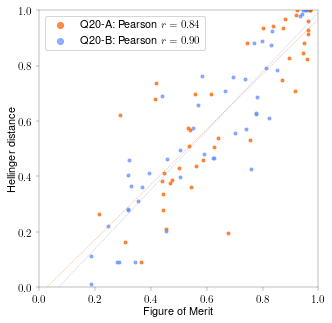

In [60]:
fig, axs = plt.subplots(figsize=(5, 5))

data = {}
for i, qpu in enumerate(qpus):

    # Collect data for plot
    model_prediction = list(y_pred[qpu])
    true_labels = list(y_test[qpu])

    ax = axs
    x = model_prediction
    y = true_labels
    xlabel = 'Figure of Merit'
    ylabel = 'Hellinger distance'

    # Normalize for Pearson correlation
    x_max, y_max = np.max(x), np.max(y)
    x_norm, y_norm = np.array(x) / x_max, np.array(y) / y_max

    # Calculate Pearson correlation
    slope, intercept, rval, pval, std_err = sp.stats.linregress(x_norm, y_norm)
    x_plot = np.linspace(np.min(x)-1, np.max(x)+1, 100)
    y_plot = (slope * (x_plot / x_max) + intercept) * y_max
    ax.plot(x_plot, y_plot, color=cols[i], linewidth=0.5, alpha=0.5, linestyle='--')

    # Should be the same as the calculated Pearson correlation
    r, p = pearsonr(x_norm, y_norm)
    assert np.isclose(r, rval), f"r: {r}, rval: {rval}"
    assert np.isclose(p, pval), f"p: {p}, pval: {pval}"

    print(f'{qpu}:  {xlabel}:')
    print(f'Pearson r: {rval:.2f}, pval: {pval:.2f}\n')

    pearson_label = names[i] + ': Pearson $r = {:.2f}$'.format(r)

    # Plot the data
    ax.scatter(x, y, color=cols[i], marker='.', label=pearson_label, alpha=0.7)

    # Adjust x-axis
    if xlabel == 'Number of gates':
        ax.set_xlim(0, 2000)
        ax.xaxis.set_major_locator(MultipleLocator(500))
    elif xlabel == 'Circuit depth':
        ax.set_xlim(0, 1000)
        ax.xaxis.set_major_locator(MultipleLocator(250))
    else:
        ax.set_xlim(0, 1)
    ax.set_xlabel(xlabel, labelpad=1)

    # Adjust y-axis
    ax.set_ylim(0., 1.0)
    ax.set_ylabel(ylabel, labelpad=1)
    ax.yaxis.set_major_locator(MultipleLocator(0.2)) 

    # Adjust tick size and tick spacing
    ax.tick_params(axis='both', which='major', width=0.25)

    # Set border line width
    for spine in ax.spines.values():
        spine.set_linewidth(0.25)

    ax.legend(scatterpoints=1)  # Adjust legend text size

    legend = ax.legend(markerscale=2.)

plt.savefig(f"{fig_path}/prediction.pdf", bbox_inches='tight')

## Feature Importance

In [61]:
def group_qubit_features(imps, names) -> tuple[np.ndarray, list]:
    """Groups qubit features and returns the grouped importances."""
    qubit_indices = [i for i, name in enumerate(names) if name.startswith('Qubit')]
    qubit_importances = imps[qubit_indices]
    qubit_importances_avg = np.average(qubit_importances, axis=0)

    # Remove individual qubit importances
    new_imps = [imps[i] for i in range(len(imps)) if i not in qubit_indices]
    new_names = [name for i, name in enumerate(names) if i not in qubit_indices]

    # Append the grouped qubit importances
    new_imps.append(qubit_importances_avg)
    new_names.append('Average qubit features')

    return np.array(new_imps), new_names

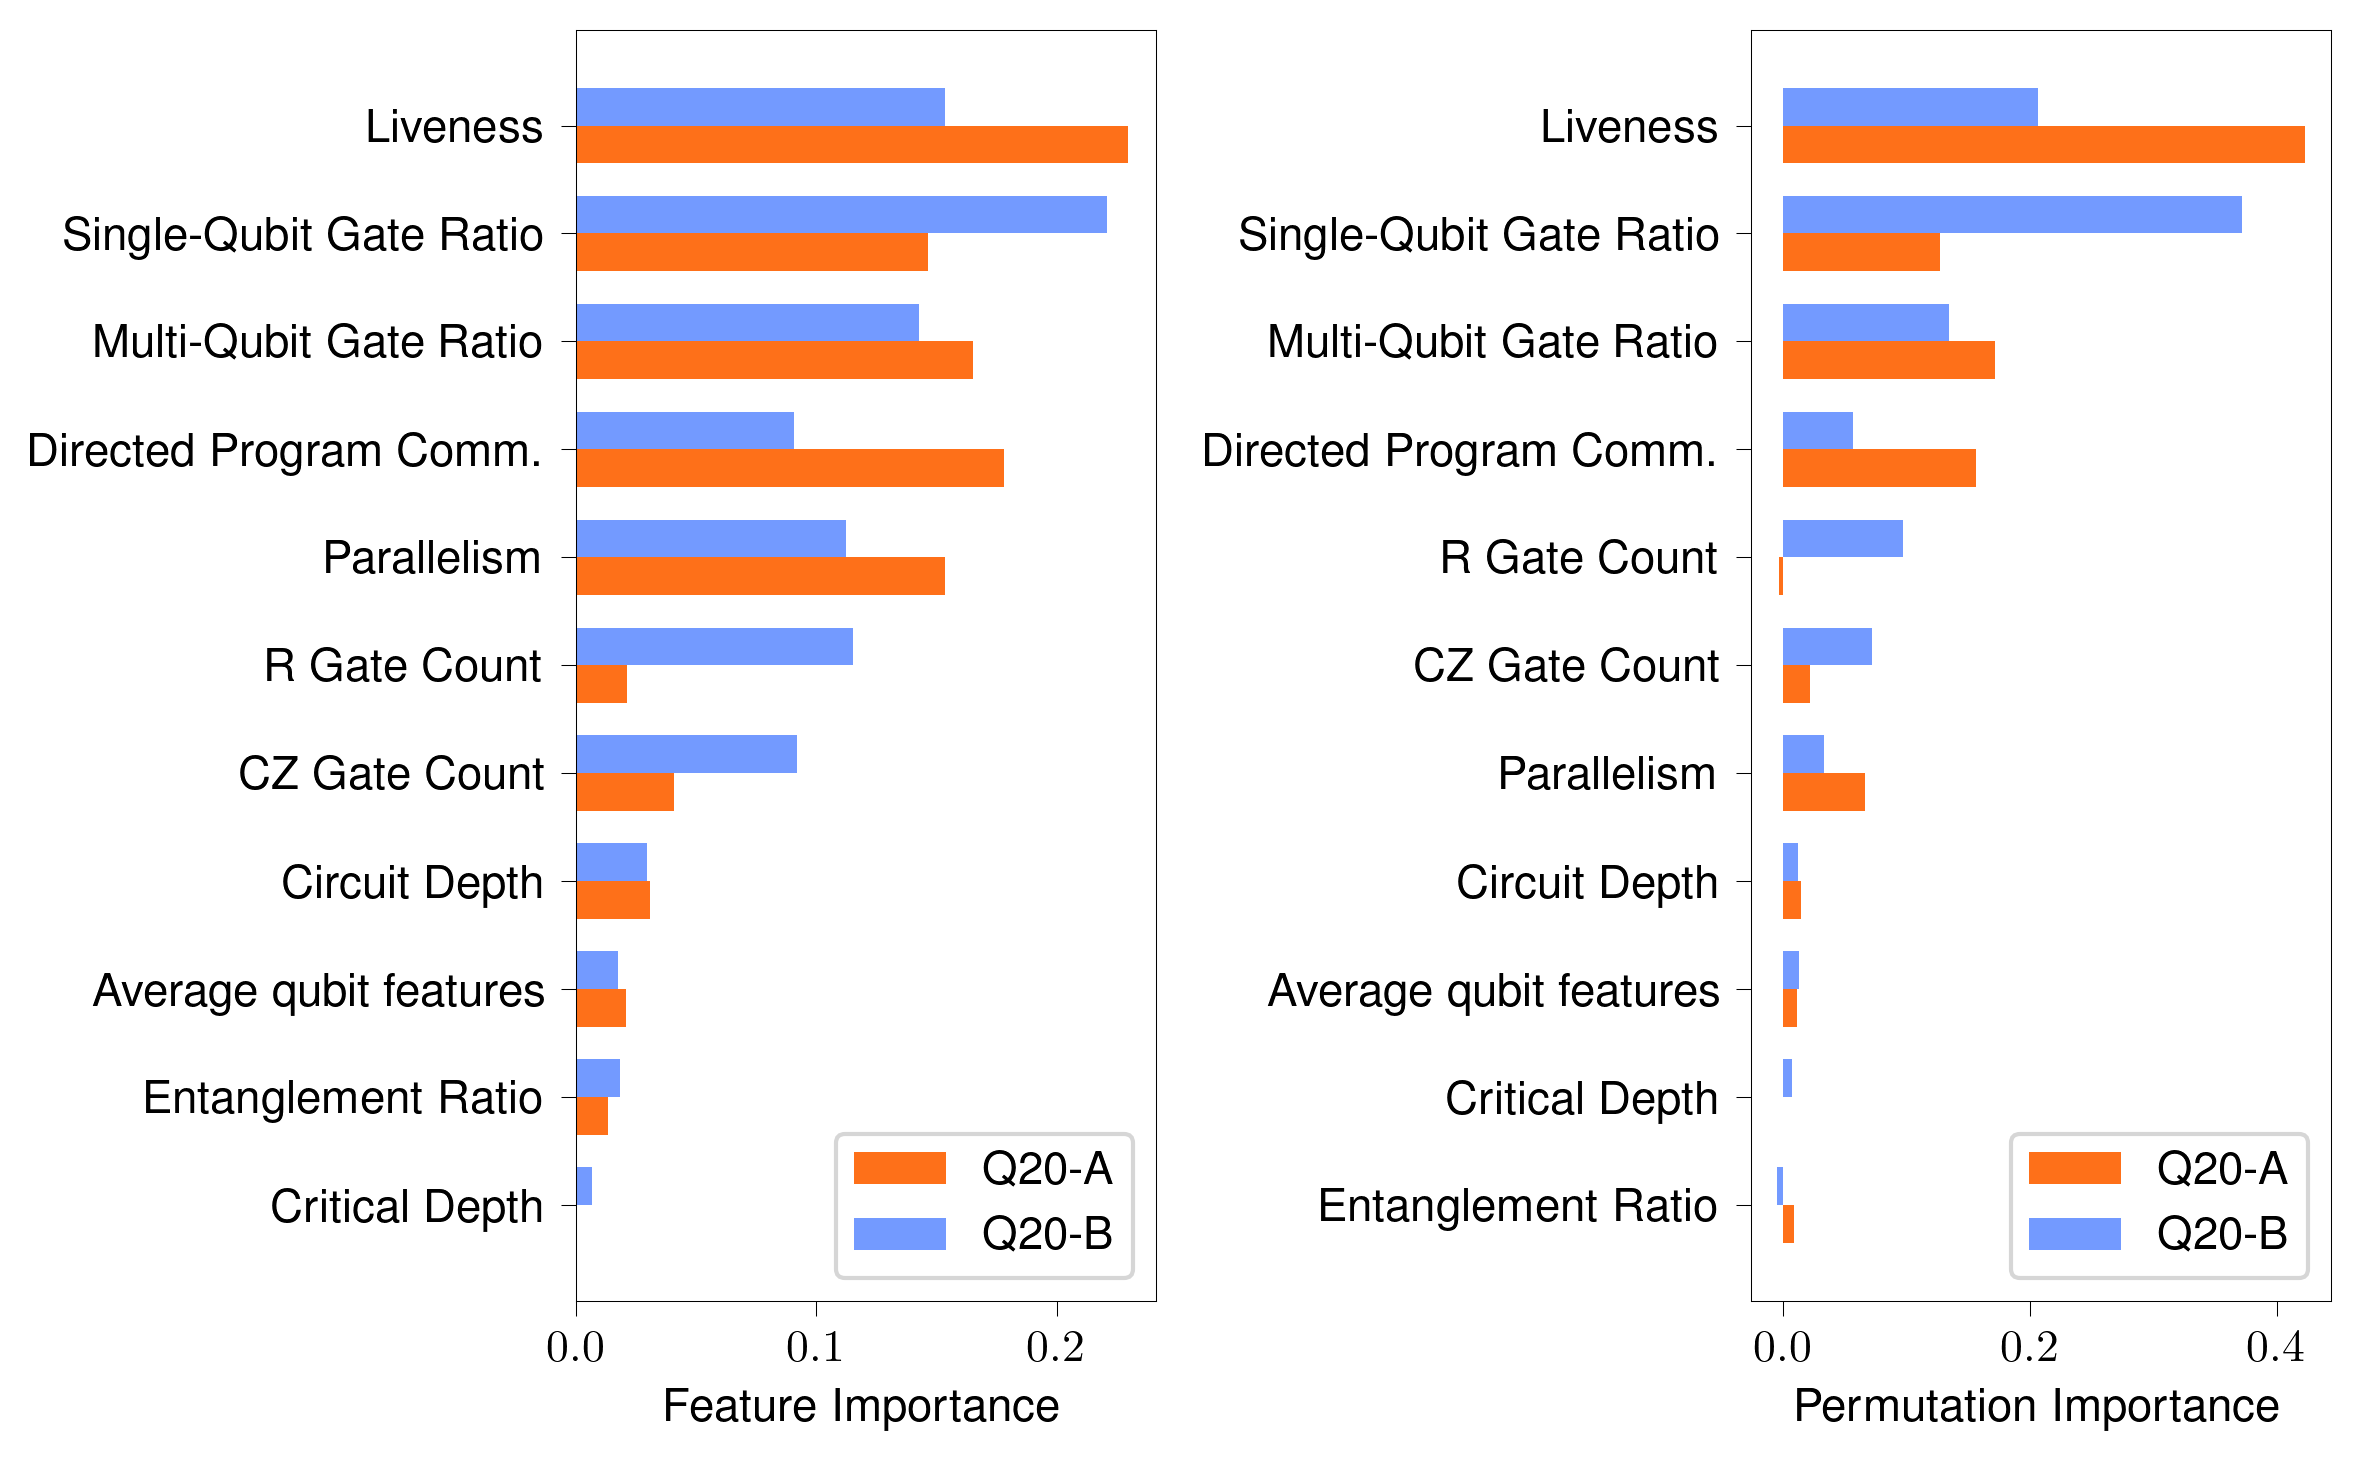

In [62]:
# Calculate feature importance for each QPU
feature_importances_apollo = best_model['apollo'].feature_importances_
feature_importances_qexa = best_model['qexa'].feature_importances_

# Feature names
feature_names = [name for name in idx_dict['apollo'].keys() if idx_dict['apollo'][name]]

# Calculate permutation importance for each QPU
perm_importances_apollo = permutation_importance(
    best_model['apollo'], X_test['apollo'], y_test['apollo'], 
    n_repeats=10, random_state=42
)['importances_mean']

perm_importances_qexa = permutation_importance(
    best_model['qexa'], X_test['qexa'], y_test['qexa'], 
    n_repeats=10, random_state=42
)['importances_mean']

# Group qubit features
perm_importances_apollo, _ = group_qubit_features(perm_importances_apollo, feature_names)
perm_importances_qexa, sorted_perm_features = group_qubit_features(perm_importances_qexa,feature_names)
feature_importances_apollo, _ = group_qubit_features(feature_importances_apollo, feature_names)
feature_importances_qexa, feature_names = group_qubit_features(feature_importances_qexa, feature_names)

# Sort by increasing importance for permutation importance plot
sorted_perm_indices = np.argsort(perm_importances_apollo + perm_importances_qexa)
perm_importances_apollo = perm_importances_apollo[sorted_perm_indices]
perm_importances_qexa = perm_importances_qexa[sorted_perm_indices]
sorted_perm_features = [feature_names[i] for i in sorted_perm_indices]    

# Sort by increasing importance for feature importance plot
sorted_indices = np.argsort(feature_importances_apollo + feature_importances_qexa)
feature_importances_apollo = feature_importances_apollo[sorted_indices]
feature_importances_qexa = feature_importances_qexa[sorted_indices]
sorted_features = [feature_names[i] for i in sorted_indices]

# Normalize feature importances
feature_importances_apollo /= feature_importances_apollo.sum()
feature_importances_qexa /= feature_importances_qexa.sum()
perm_importances_apollo /= perm_importances_apollo.sum()
perm_importances_qexa /= perm_importances_qexa.sum()

# Plot settings
labels = ['Q20-A', 'Q20-B']
width = 0.35  # Bar width

fig, axs = plt.subplots(1, 2, figsize=(8, 5), dpi=300)

# Plot feature importance
x = np.arange(len(sorted_features))
axs[0].barh(x - width/2, feature_importances_apollo, width, label=labels[0], color=cols[0], alpha=0.9)
axs[0].barh(x + width/2, feature_importances_qexa, width, label=labels[1], color=cols[1], alpha=0.9)
axs[0].set_yticks(x)
axs[0].set_yticklabels(sorted_features)
axs[0].set_xlabel('Feature Importance')
axs[0].legend(loc='lower right')
for spine in axs[0].spines.values():
    spine.set_linewidth(0.25)
axs[0].tick_params(axis='both', which='major', width=0.25)

# Plot permutation importance
x = np.arange(len(sorted_perm_features))
axs[1].barh(x - width/2, perm_importances_apollo, width, label=labels[0], color=cols[0], alpha=0.9)
axs[1].barh(x + width/2, perm_importances_qexa, width, label=labels[1], color=cols[1], alpha=0.9)
axs[1].set_yticks(x)
axs[1].set_yticklabels(sorted_perm_features)
axs[1].set_xlabel('Permutation Importance')
axs[1].legend(loc='lower right')
for spine in axs[1].spines.values():
    spine.set_linewidth(0.25)
axs[1].tick_params(axis='both', which='major', width=0.25)

# Adjust layout and save the plot
fig.tight_layout()
fig.savefig(f"{fig_path}/importance.pdf", bbox_inches='tight')